In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

# Load MobileNetV2 with pretrained weights
mobilenet = models.mobilenet_v2(pretrained=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load image
img = Image.open("car.jpg").convert('RGB')
img = transform(img).unsqueeze(0)

mobilenet.eval()
with torch.no_grad():
    outputs = mobilenet(img)
    probabilities = torch.softmax(outputs, dim=1)
    top_probs, top_classes = probabilities.topk(3, dim=1)
    top_probs = top_probs.squeeze().tolist()
    top_classes = top_classes.squeeze().tolist()

for i in range(3):
    print(f"Probability {i+1}:", idx2label[top_classes[i]], top_probs[i])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Probability 1: sports car, sport car 0.8446143865585327
Probability 2: racer, race car, racing car 0.14706873893737793
Probability 3: passenger car, coach, carriage 0.0033789584413170815


In [ ]:
data_dir = '/path_to/oxford102_flowers'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True, pin_memory=True)

val_dataset = datasets.Flowers102(root='data', split='val', download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False, pin_memory=True)


test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False, pin_memory=True)


In [ ]:
def layer_init(layer, std, bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

# Freeze MobileNetV2 layers
for param in mobilenet.features.parameters():
    param.requires_grad = False


num_classes = 102
mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            layer_init(nn.Linear(mobilenet.last_channel, 256), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(256, num_classes), std=0.01)
)

mobilenet = mobilenet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)


def train_model(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss/len(dataloader), correct/total


def validate_model(model, dataloader, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss/len(dataloader), correct/total


In [ ]:
num_epochs = 25
history = np.zeros((num_epochs, 4))

for epoch in range(num_epochs):
    train_loss, train_accuracy  = train_model(mobilenet, train_loader, criterion, optimizer)
    validation_loss, val_accuracy  = validate_model(mobilenet, val_loader, criterion, optimizer)
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/25, Train Loss: 4.5880, Validation Loss: 4.5114, Train Accuracy: 0.0225, Validation Accuracy: 0.0441
Epoch 2/25, Train Loss: 4.3976, Validation Loss: 4.2015, Train Accuracy: 0.0510, Validation Accuracy: 0.0804
Epoch 3/25, Train Loss: 4.0119, Validation Loss: 3.7397, Train Accuracy: 0.1000, Validation Accuracy: 0.1941
Epoch 4/25, Train Loss: 3.5732, Validation Loss: 3.3528, Train Accuracy: 0.1804, Validation Accuracy: 0.2637
Epoch 5/25, Train Loss: 3.2193, Validation Loss: 3.0498, Train Accuracy: 0.2716, Validation Accuracy: 0.3304
Epoch 6/25, Train Loss: 2.8934, Validation Loss: 2.7898, Train Accuracy: 0.3412, Validation Accuracy: 0.3794
Epoch 7/25, Train Loss: 2.6283, Validation Loss: 2.5601, Train Accuracy: 0.3843, Validation Accuracy: 0.4137
Epoch 8/25, Train Loss: 2.4045, Validation Loss: 2.3985, Train Accuracy: 0.4500, Validation Accuracy: 0.4186
Epoch 9/25, Train Loss: 2.1984, Validation Loss: 2.2372, Train Accuracy: 0.4853, Validation Accuracy: 0.4578
Epoch 10/25, Train 

In [ ]:
train_loss, train_accuracy = validate_model(mobilenet, train_loader, criterion, optimizer)
validation_loss, validation_accuracy = validate_model(mobilenet, val_loader, criterion, optimizer)
test_loss, test_accuracy = validate_model(mobilenet, test_loader, criterion, optimizer)

print(f"MobileNet V2 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"MobileNet V2 - Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.4f}")
print(f"MobileNet V2 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

MobileNet V2 - Train Loss: 0.6424, Train Accuracy: 0.8569
MobileNet V2 - Val Loss: 1.3937, Val Accuracy: 0.6275
MobileNet V2 - Test Loss: 1.4621, Test Accuracy: 0.6133


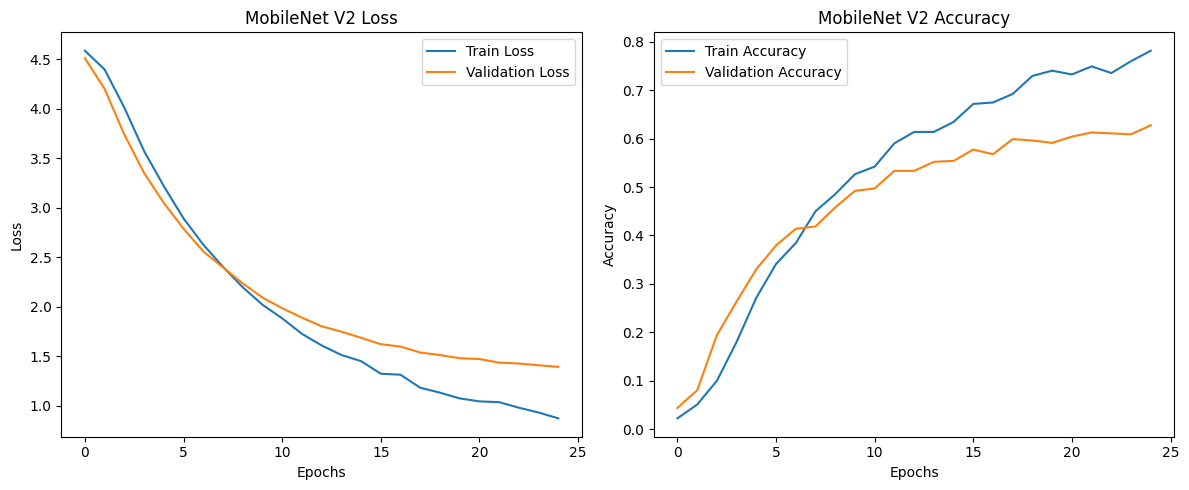

In [ ]:
# Plot training and validation metrics
import matplotlib.pyplot as plt


def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history[:, 0], label="Train Loss")
    plt.plot(history[:, 1], label="Validation Loss")
    plt.title(model_name + " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history[:, 2], label="Train Accuracy")
    plt.plot(history[:, 3], label="Validation Accuracy")
    plt.title(model_name + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history, "MobileNet V2")

In [ ]:
# Load pre-trained models
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False


num_classes = 102
vgg16.classifier = nn.Sequential(
            nn.Dropout(0.5),
            layer_init(nn.Linear(512 * 7 * 7, 256), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(256, num_classes), std=0.01)
)



vgg16 = vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)


num_epochs = 15
history = np.zeros((num_epochs, 4))

for epoch in range(num_epochs):
    train_loss, train_accuracy  = train_model(vgg16, train_loader, criterion, optimizer)
    validation_loss, val_accuracy  = validate_model(vgg16, val_loader, criterion, optimizer)
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/15, Train Loss: 4.3865, Validation Loss: 3.5054, Train Accuracy: 0.0441, Validation Accuracy: 0.2020
Epoch 2/15, Train Loss: 2.3667, Validation Loss: 2.0193, Train Accuracy: 0.4235, Validation Accuracy: 0.4510
Epoch 3/15, Train Loss: 0.5945, Validation Loss: 1.3881, Train Accuracy: 0.8794, Validation Accuracy: 0.6029
Epoch 4/15, Train Loss: 0.1019, Validation Loss: 1.2586, Train Accuracy: 0.9882, Validation Accuracy: 0.6598
Epoch 5/15, Train Loss: 0.0248, Validation Loss: 1.1278, Train Accuracy: 0.9990, Validation Accuracy: 0.6833
Epoch 6/15, Train Loss: 0.0062, Validation Loss: 1.0668, Train Accuracy: 1.0000, Validation Accuracy: 0.7167
Epoch 7/15, Train Loss: 0.0035, Validation Loss: 1.0623, Train Accuracy: 1.0000, Validation Accuracy: 0.7098
Epoch 8/15, Train Loss: 0.0022, Validation Loss: 1.0577, Train Accuracy: 1.0000, Validation Accuracy: 0.7157
Epoch 9/15, Train Loss: 0.0016, Validation Loss: 1.0530, Train Accuracy: 1.0000, Validation Accuracy: 0.7137
Epoch 10/15, Train 

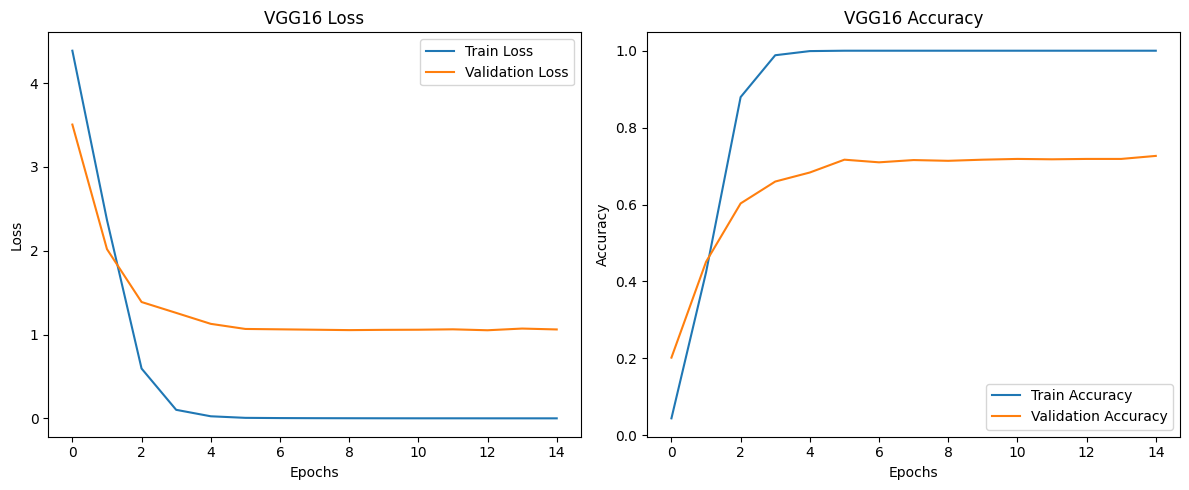

VGG16 - Train Loss: 0.0001, Train Accuracy: 1.0000
VGG16 - Val Loss: 1.0609, Val Accuracy: 0.7265
VGG16 - Test Loss: 1.1800, Test Accuracy: 0.7039


In [ ]:
plot_history(history, "VGG16")

train_loss, train_accuracy = validate_model(vgg16, train_loader, criterion, optimizer)
validation_loss, validation_accuracy = validate_model(vgg16, val_loader, criterion, optimizer)
test_loss, test_accuracy = validate_model(vgg16, test_loader, criterion, optimizer)

print(f"VGG16 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"VGG16 - Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.4f}")
print(f"VGG16 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

#print(resnet50.fc.in_features)

num_classes = 102
resnet50.fc = nn.Sequential(
            nn.Dropout(0.2),
            layer_init(nn.Linear(resnet50.fc.in_features, 2048), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(2048, num_classes), std=0.01)
)

resnet50 = resnet50.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)


num_epochs = 25
history = np.zeros((num_epochs, 4))

for epoch in range(num_epochs):
    train_loss, train_accuracy  = train_model(resnet50, train_loader, criterion, optimizer)
    validation_loss, val_accuracy  = validate_model(resnet50, val_loader, criterion, optimizer)
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/25, Train Loss: 4.6283, Validation Loss: 4.6052, Train Accuracy: 0.0127, Validation Accuracy: 0.0412
Epoch 2/25, Train Loss: 4.5363, Validation Loss: 4.3637, Train Accuracy: 0.0314, Validation Accuracy: 0.0657
Epoch 3/25, Train Loss: 4.0853, Validation Loss: 3.6601, Train Accuracy: 0.0902, Validation Accuracy: 0.2225
Epoch 4/25, Train Loss: 3.3559, Validation Loss: 3.0113, Train Accuracy: 0.2167, Validation Accuracy: 0.3451
Epoch 5/25, Train Loss: 2.6805, Validation Loss: 2.5481, Train Accuracy: 0.3863, Validation Accuracy: 0.3980
Epoch 6/25, Train Loss: 2.1577, Validation Loss: 2.1584, Train Accuracy: 0.4990, Validation Accuracy: 0.4608
Epoch 7/25, Train Loss: 1.7454, Validation Loss: 1.8486, Train Accuracy: 0.5980, Validation Accuracy: 0.5529
Epoch 8/25, Train Loss: 1.4979, Validation Loss: 1.6472, Train Accuracy: 0.6363, Validation Accuracy: 0.6049
Epoch 9/25, Train Loss: 1.2742, Validation Loss: 1.4861, Train Accuracy: 0.7186, Validation Accuracy: 0.6363
Epoch 10/25, Train 

ResNet50 - Train Loss: 0.0977, Train Accuracy: 0.9892
ResNet50 - Val Loss: 0.8810, Val Accuracy: 0.7735
ResNet50 - Test Loss: 1.0240, Test Accuracy: 0.7377


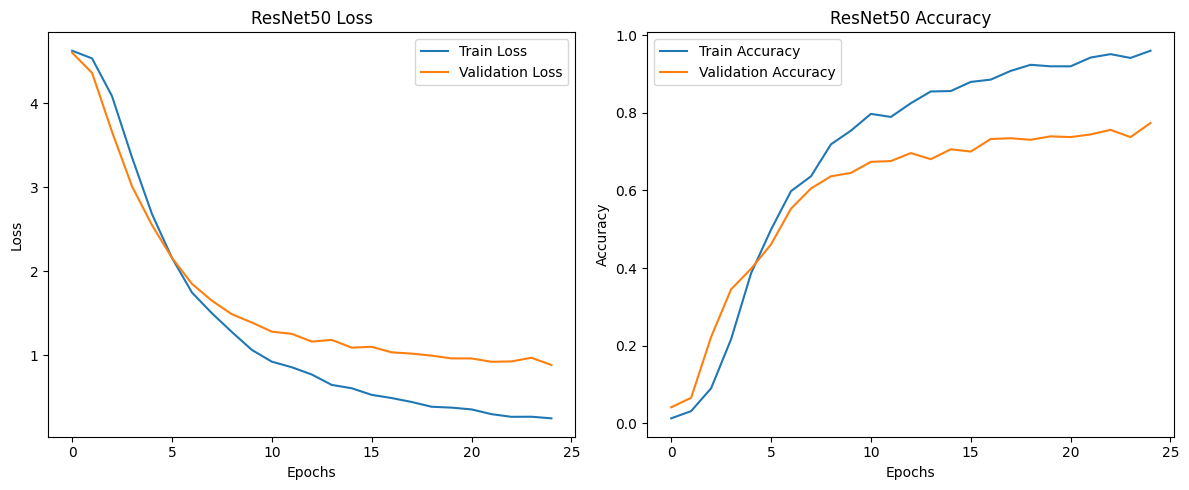

In [ ]:
train_loss, train_accuracy = validate_model(resnet50, train_loader, criterion, optimizer)
validation_loss, validation_accuracy = validate_model(resnet50, val_loader, criterion, optimizer)
test_loss, test_accuracy = validate_model(resnet50, test_loader, criterion, optimizer)

print(f"ResNet50 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"ResNet50 - Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.4f}")
print(f"ResNet50 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

plot_history(history, "ResNet50")

In [ ]:
# Load MobileNetV2 with pretrained weights
mobilenet = models.mobilenet_v2(pretrained=True)

num_classes = 102
mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(mobilenet.last_channel, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
)

# weight initialization
for m in mobilenet.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

mobilenet = mobilenet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 25
history = np.zeros((num_epochs, 4))


for epoch in range(num_epochs):
    train_loss, train_accuracy  = train_model(mobilenet, train_loader, criterion, optimizer)
    validation_loss, val_accuracy  = validate_model(mobilenet, val_loader, criterion, optimizer)
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


train_loss, train_accuracy = validate_model(mobilenet, train_loader, criterion, optimizer)
validation_loss, validation_accuracy = validate_model(mobilenet, val_loader, criterion, optimizer)
test_loss, test_accuracy = validate_model(mobilenet, test_loader, criterion, optimizer)

print(f"MobileNet V2 Random - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"MobileNet V2 Random - Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.4f}")
print(f"MobileNet V2 Random - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch 1/25, Train Loss: 4.6239, Validation Loss: 5.4863, Train Accuracy: 0.0088, Validation Accuracy: 0.0147
Epoch 2/25, Train Loss: 4.4262, Validation Loss: 4.4885, Train Accuracy: 0.0127, Validation Accuracy: 0.0216
Epoch 3/25, Train Loss: 4.2619, Validation Loss: 4.3410, Train Accuracy: 0.0108, Validation Accuracy: 0.0206
Epoch 4/25, Train Loss: 4.1892, Validation Loss: 4.1710, Train Accuracy: 0.0118, Validation Accuracy: 0.0216
Epoch 5/25, Train Loss: 4.1110, Validation Loss: 4.3924, Train Accuracy: 0.0206, Validation Accuracy: 0.0216
Epoch 6/25, Train Loss: 4.0429, Validation Loss: 4.1094, Train Accuracy: 0.0294, Validation Accuracy: 0.0255
Epoch 7/25, Train Loss: 4.0306, Validation Loss: 4.2971, Train Accuracy: 0.0206, Validation Accuracy: 0.0265
Epoch 8/25, Train Loss: 3.9389, Validation Loss: 4.0841, Train Accuracy: 0.0324, Validation Accuracy: 0.0314
Epoch 9/25, Train Loss: 3.8702, Validation Loss: 4.1319, Train Accuracy: 0.0353, Validation Accuracy: 0.0500
Epoch 10/25, Train 

NameError: name 'plt' is not defined

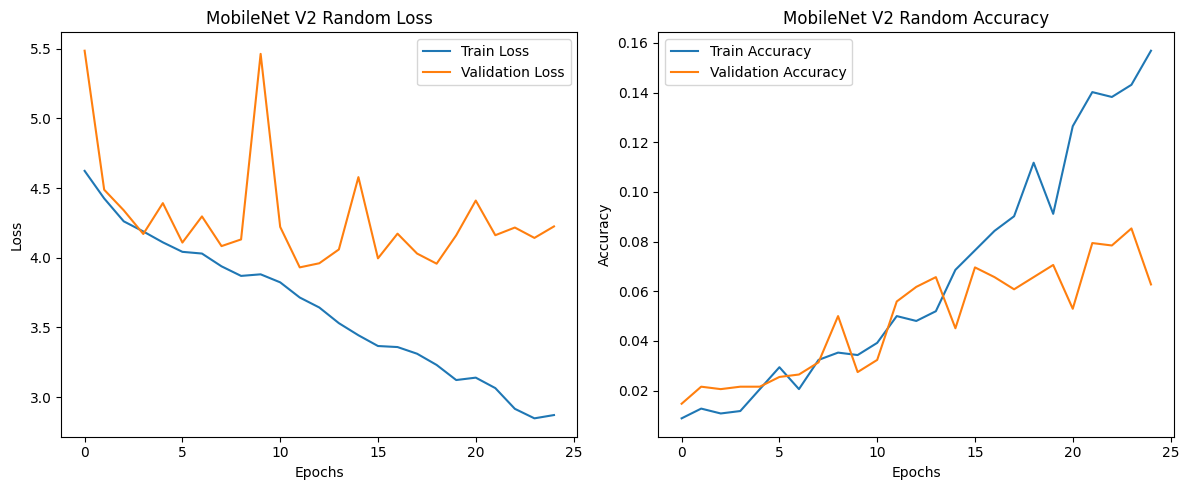

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history[:, 0], label="Train Loss")
    plt.plot(history[:, 1], label="Validation Loss")
    plt.title(model_name + " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history[:, 2], label="Train Accuracy")
    plt.plot(history[:, 3], label="Validation Accuracy")
    plt.title(model_name + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history, "MobileNet V2 Random")